In [81]:
import warnings
warnings.filterwarnings('ignore')

import datetime
from nlp_pipeline.nlp_pipeline import nlp_processor
import pandas as pd

# Example usage of nlp_pipeline library
## Table of Contents
* [Initial document list](#1)
    * [Inputting the document list information to the metadata file](#1.1)
* [Downloading/processing the files](#2)
    * [Download the files](#2.1)
    * [Convert the files to text](#2.2)
    * [Transform the text](#2.3)
* [Creating data from the files](#3)
    * [Generate a CSV with word counts](#3.1)
    * [Generate a CSV with entity counts](#3.2)
    * [Generate a CSV with sentiment scores](#3.3)
    * [Generate various summary statistics about the documents](#3.4)
* [Visualizations from the data](#4)
    * [Bar plot of most common words in the documents](#4.1)
    * [Word cloud of most common words in the documents](#4.2)
    * [Line plot of occurrences of a word over time](#4.3)
    * [Plot sentiment over time](#4.4)
    * [Plot data from the summary statistics CSV](#4.5)
    * [Plot a heatmap of text similarities](#4.6)
    * [Plot a cluster chart of text similarities](#4.7)
* [Topic modelling with BERTopic](#5)
    * [Visualize a BERTopic model](#5.1)

## Initial document list <a class="anchor" id="1"></a>
For this example, we will be examining the IMF annual report from 2018-2022. The first step is to gather the documents in the corpus you would like to analyze. In this example, this initial information is stored in the `document_list.csv`. Within that document, there is a column for the web URL and a column for the year of the publication. If you already have a corpus of local text documents (i.e., already in `.txt` format), in place of the URL you can put the the local path to the file.

In [5]:
# initialize the processor and create directory structure
processor = nlp_processor(
    data_path = "data/",
    metadata_addt_column_names = ["year"],
    windows_tesseract_path = r"path\tesseract.exe",
    windows_poppler_path = r"path\poppler-0.68.0\bin"
)

The library will automatically create the directory structure required in the location specified by the `data_path` argument. This can be wherever you wish to store the files and need not be an existing directory. The `metadata_addt_column_names` argument is a list containing any additional columns of information you want to include on each document. In this case there is only one, the `year` column. On Unix systems, you don't need to pass anything for the `windows_tesseract_path` and `windows_poppler_path` parameters, they just need to be installed on your system. On Windows, point them to your `tesseract.exe` and poppler `bin` files, respectively. These two arguments are for PDF to text conversion in case OCR is required. If you are dealing with only HTML or text files, they will not be required.

**Inputting the document list information to the metadata file**<br> <a class="anchor" id="1.1"></a>
Nonw, within the `data/` directory you will find a newly created `metadata.csv` file. Open it up and paste in the URL/local filepaths to the documents in the `web_filepath` as well as any additional columns created via the `metadata_addt_column_names` parameter. In this case it is also the `year` column. At this point we no longer need the `document_list.csv` file.

## Downloading/processing the files <a class="anchor" id="2"></a>
The next steps are to sync the metadata file to generate text IDs and then download the files (if necessary) and convert them to text

In [ ]:
# sync the metadata file to generate text ids
processor.refresh_object_metadata()
processor.sync_local_metadata()

Now if you open the `metadata.csv` file you will see the `text_id` column is filled. Generally speaking, you can run the `refresh_object_metadata()` if you make changes to the local metadata file and want them reflected in the `nlp_processor` object. And you can run the `sync_local_metadata()` function to ensure the metadata file reflects the local file situation. For example, if you delete a document from the local directory, running this function will reflect that in the metadata file.

**Download the files** <a class="anchor" id="2.1"></a>

In [ ]:
text_ids = list(processor.metadata.text_id.values) # we want to download all the documents in the metadata
processor.download_text_id(text_ids = text_ids) # download the files. If the `web_filepath` column contains local paths to text files, this function will simply rename and copy them to the location necessary for the library

In the `data/raw_files/` directory, you will now find the local documents with the naming convention of `{text_id}.pdf/html/txt`.

**Convert the files to text** <a class="anchor" id="2.2"></a>

In [ ]:
processor.convert_to_text(text_ids = text_ids)

If a PDF cannot be converted to text (e.g., is a scan) or has errors in the text conversion, it will be converted via OCR, which may take some time depending on how many files need to be OCR converted. When complete, you will find the converted text files in the `data/txt_files/` path.

**Transform the text**<br> <a class="anchor" id="2.3"></a>
The text now can be transformed with various operations.

In [ ]:
# small amount of cleaning
processor.transform_text(
    text_ids = text_ids,
    path_prefix = "minimum_cleaning", # what these transformed text files will be prefixed with
    perform_lower = True, # lower case the text
    perform_replace_newline_period = True, # replace new line 
    perform_remove_punctuation = True
)

This code will lower case the text, remove punctuation marks, and replace newlines and periods with "|" for a standardized phrase separator. The transformed text files can be found in the `data/transformed_txt_files/` directory, with the naming convention `{path_prefix}_{text_id}.txt`

In [ ]:
# maximum amount of cleaning
processor.transform_text(
    text_ids = text_ids,
    path_prefix = "stemmed", # what these transformed text files will be prefixed with
    perform_lower = True, # lower case the text
    perform_replace_newline_period = True, # replace new line 
    perform_remove_punctuation = True,
    perform_remove_stopwords = True,
    perform_stemming = True,
    stemmer = "snowball"
)

This code will perform all of the transformations as the above code, plus remove stopwords (common words in the language, like "and", "but", etc.) and stem the text. Stemming truncates words to their core meaning. For instance, "running" and "runs" would both be converted to "run".

## Creating data from the files <a class="anchor" id="3"></a>
Now that the texts are available and ready for processing, we can start to calculate various datasets from them.

**Generate a CSV with word counts** <a class="anchor" id="3.1"></a>

In [ ]:
# generate a word count dictionary with the "minimum_cleaning" text files
processor.gen_word_count_csv(
    text_ids = text_ids,
    path_prefix = "minimum_cleaning",
    exclude_words = [] # a list of any words you would like to exclude from the word count dictionaries
)

# generate a word count dictionary with the "stemmed" text files
processor.gen_word_count_csv(
    text_ids = text_ids,
    path_prefix = "stemmed",
    exclude_words = []
)

In the `data/csv_outputs/` directory you will now find two new CSVs, with the naming convention `{path_prefix}_word_counts.csv`. These contain text IDs in one column and Python dictionaries of word counts in another.

In [18]:
data = pd.read_csv(f"{processor.data_path}/csv_outputs/stemmed_word_counts.csv")
data.head()

text_id                                    word_count_dict
0        1  {'7cot': 1, 'hoday': 1, 'jenuuy': 1, 'ji': 1, ...
1        2  {'build': 44, 'forward': 39, 'better': 40, 'im...
2        3  {'year': 84, 'like': 53, 'imf': 276, 'annual':...
3        4  {'polici': 282, 'tackl': 12, 'corrupt': 18, 'i...
4        5  {'intern': 166, 'monetari': 109, 'fund': 141, ...

**Generate a CSV with entity counts**<br> <a class="anchor" id="3.2"></a>
We can do the same for entities. Entities can be multi-word phrases that encapsulate various concepts.

In [ ]:
processor.gen_entity_count_csv(text_ids)

In the `data/csv_outputs/` directory you will now find an `entity_count.csv` file. Similarly to the word counts CSV, this contains a column of text IDs and a Python dictionary of entity counts. The entities are stored in the format of `{entity_name}|{entity_label}`. Labels are the following ([source](https://www.dataknowsall.com/ner.html)):
* PERSON:      People, including fictional.
* NORP:        Nationalities or religious or political groups.
* FAC:         Buildings, airports, highways, bridges, etc.
* ORG:         Companies, agencies, institutions, etc.
* GPE:         Countries, cities, states.
* LOC:         Non-GPE locations, mountain ranges, bodies of water.
* PRODUCT:     Objects, vehicles, foods, etc. (Not services.)
* EVENT:       Named hurricanes, battles, wars, sports events, etc.
* WORK_OF_ART: Titles of books, songs, etc.
* LAW:         Named documents made into laws.
* LANGUAGE:    Any named language.
* DATE:        Absolute or relative dates or periods.
* TIME:        Times smaller than a day.
* PERCENT:     Percentage, including ”%“.
* MONEY:       Monetary values, including unit.
* QUANTITY:    Measurements, as of weight or distance.
* ORDINAL:     “first”, “second”, etc.
* CARDINAL:    Numerals that do not fall under another type.

In [20]:
data = pd.read_csv(f"{processor.data_path}/csv_outputs/entity_counts.csv")
data.head()

text_id                                  entity_count_dict
0        1  {'IMF|ORG': 272, 'CRISIS|ORG': 47, '2022|DATE'...
1        2  {'IMF|ORG': 245, '2021|DATE': 47, 'RCF|ORG': 3...
2        3  {'IMF|ORG': 147, 'M SDR|ORG': 29, '11|CARDINAL...
3        4  {'IMF|ORG': 505, 'FY2019|DATE': 56, 'the Execu...
4        5  {'IMF|ORG': 507, 'the Executive Board|ORG': 43...

**Generate a CSV with sentiment scores**<br> <a class="anchor" id="3.3"></a>
We can also generate a CSV with sentiment scores, or how positive or negative a text is.

In [ ]:
processor.gen_sentiment_csv(
    text_ids = text_ids, 
    path_prefix = "minimum_cleaning"
)

This will produce a CSV in `data/csv_outputs/{path_prefix}_sentiments.csv` which contains four columns: 
* `text_id`: text IDs
* `avg_sentiment_w_neutral`: average sentiment score of the document including neutral phrases (higher = more positive, lower = more negative)
* `avg_sentiment_wo_neutral`: average sentiment score of the document excluding neutral phrases
* `neutral_proportion`: proportion of sentences in the text that have a neutral sentiment

In [22]:
data = pd.read_csv(f"{processor.data_path}/csv_outputs/minimum_cleaning_sentiments.csv")
data.head()

text_id  avg_sentiment_w_neutral  avg_sentiment_wo_neutral  \
0        1                 0.030555                  0.110277   
1        2                 0.048017                  0.190900   
2        3                 0.042338                  0.166562   
3        4                 0.091160                  0.253000   
4        5                 0.088852                  0.274659   

   neutral_proportion  
0            0.722926  
1            0.748469  
2            0.745810  
3            0.639682  
4            0.676502

We can see that the years with the lowest sentiment (most negative) are 2022 and 2020, most likely due to the conflict in Ukraine and the COVID-19 pandemic, respectively. We can also generate a sentence-by-sentence sentiment report for either a completely new text, or one of the text IDs.

In [24]:
# generate a sentiment report for a completely new text
new_text = "This is a positive sentence. Everything is very good. Except for the numerous things that are bad. Some are neutral however."
processor.gen_sentiment_report(stringx = new_text)

sentence_number                                        sentence  sentiment
0                1                    this is a positive sentence      0.5994
1                2                        everything is very good      0.4927
2                3    except for the numerous things that are bad     -0.5423
3                4                       some are neutral however      0.0000

In [25]:
# generate a sentiment report for a text in the corpus
sentiment_report = processor.gen_sentiment_report(text_id = 1)

In [30]:
sentiment_report.iloc[1:4, :]

sentence_number                                   sentence  sentiment
1                2   the pandemic was a crisis like no other     -0.5859
2                3    two years later  the recovery has been      0.0000
3                4    hampered by further crisis upon crisis     -0.8481

**Generate various summary statistics about the documents** <a class="anchor" id="3.4"></a>

In [ ]:
processor.gen_summary_stats_csv(
    text_ids = text_ids, 
    path_prefix = "minimum_cleaning"
)

Now we can find a CSV in `data/csv_outputs/{path_prefix}_summary_stats.csv`. It contains the following columns:
* `text_id`: text ID
* `n_words`: number of words in the text
* `n_unique_words`: number of unique words in the text
* `n_sentences`: number of sentences in the text
* `avg_word_length`: average number of letters in each word in the text
* `avg_word_incidence`: average incidence of words in the text (higher is more frequent/common words, a word with Zipf value 6 appears once per thousand words and a word with Zipf value 3 appears once per million words)
* `num_chars_numeric`: number of numeric (0-9) characters in the text
* `num_chars_alpha`: number of alpha (letter) characters in the text
* `numeric_proportion`: num_chars_numeric / (num_chars_numeric + num_chars_alpha)

In [32]:
data = pd.read_csv(f"{processor.data_path}/csv_outputs/minimum_cleaning_summary_stats.csv")
data.head()

text_id  n_words  n_unique_words  n_sentences  n_pages  avg_word_length  \
0        1    20999            3488         4262       80         7.203673   
1        2    20168            3371         2533       74         6.631785   
2        3    14113            2933         2229       68         6.554016   
3        4    43117            5512         4586      108         6.461292   
4        5    43393            5717         5217      108         6.443981   

   avg_word_incidence  num_chars_numeric  num_chars_alpha  numeric_proportion  
0            5.049942               4114           112152            0.035384  
1            4.940207               8171           100344            0.075298  
2            4.916274               3320            73815            0.043041  
3            5.227390               6391           237922            0.026159  
4            5.177281               5914           241761            0.023878

## Visualizations from the data <a class="anchor" id="4"></a>

**Bar plot of most common words in the documents** <a class="anchor" id="4.1"></a>

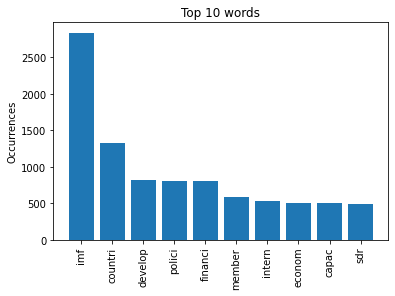

In [37]:
p, plot_df = processor.bar_plot_word_count(
    text_ids = text_ids, 
    path_prefix = "stemmed",
    n_words = 10, # top n words to show
    title = "Top 10 words"
)

**Word cloud of most common words in the documents** <a class="anchor" id="4.2"></a>

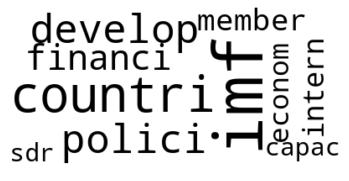

In [39]:
p, plot_df = processor.word_cloud(
    text_ids = text_ids, 
    path_prefix = "stemmed",
    n_words = 10 # top n words to show
)

**Line plot of occurrences of a word over time** <a class="anchor" id="4.3"></a>

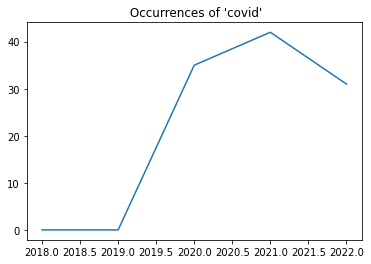

In [46]:
p, plot_df = processor.plot_word_occurrences(
    text_ids_list = text_ids, # can be a list of lists, [[1,2,3], [4,5,6]], for counts by decade e.g.
    word = "covid", 
    path_prefix = "minimum_cleaning",
    x_labels = [2022, 2021, 2020, 2019, 2018],
    title = ""
)

Here we can see how the usage of COVID went from 0 in the 2018 and 2019 editions, to more than 30 and 40 mentions in the 2020 and 2021 editions, before declining again in the 2022 edition.

In [49]:
p, plot_df = processor.plot_word_occurrences(
    text_ids_list = [[2,3,4,5], [1]], # can be a list of lists, [[1,2,3], [4,5,6]], for counts by decade e.g.
    word = "ukraine", 
    path_prefix = "minimum_cleaning",
    x_labels = ["2018-2021", "2022"],
    title = ""
)

By passing a list of lists, we can also group texts together for this plot. For instance this plot shows how cumulatively between 2018 and 2021 'Ukraine' was only mentioned 14 times. But in 2022 alone it was mentioned 25 times.

**Plot sentiment over time** <a class="anchor" id="4.4"></a>

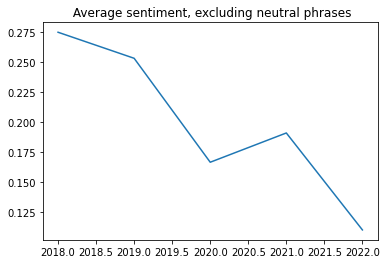

In [52]:
p, plot_df = processor.plot_sentiment(
    text_ids_list = text_ids, 
    path_prefix = "minimum_cleaning", 
    x_labels = [2022, 2021, 2020, 2019, 2018],
    sentiment_col = "avg_sentiment_wo_neutral",
    title = ""
)

We can see that sentiment declined precipitously in 2020, before recovering in 2021, then dropping even further in 2022. Any of the columns in the `data/csv_outputs/{path_prefix}_sentiments.csv` file can be plotted this way by passing their name to the `sentiment_col` argument.

**Plot data from the summary statistics CSV** <a class="anchor" id="4.5"></a>

True


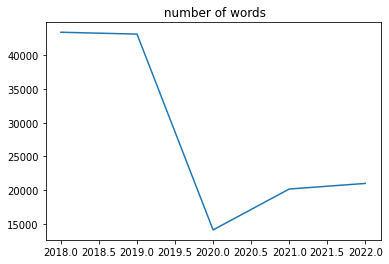

In [54]:
p, plot_df = processor.plot_summary_stats(
    text_ids_list = text_ids, 
    path_prefix = "minimum_cleaning", 
    x_labels = [2022, 2021, 2020, 2019, 2018],
    summary_stats_col = "n_words", # one of: n_words, n_unique_words, n_sentences, n_pages, avg_word_length, avg_word_incidence, num_chars_numeric, num_chars_alpha, numeric_proportion
    title = ""
)

We can see that the report underwent a rewrite in 2020, greatly reducing the number of words in each document. Any of the columns in the `data/csv_outputs/{path_prefix}_summary_stats.csv` file can be plotted this way by passing their name to the `summary_stats_col` argument.

**Plot a heatmap of text similarities** <a class="anchor" id="4.6"></a>

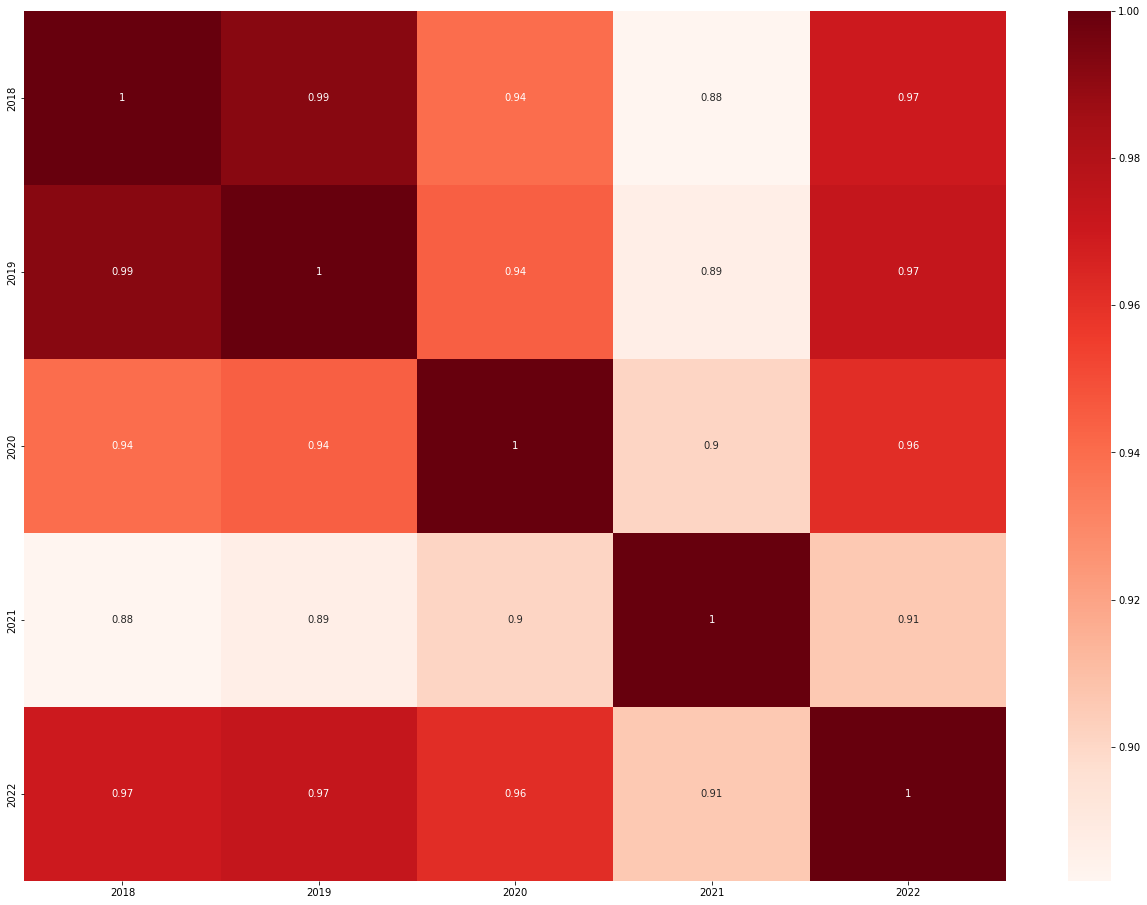

In [64]:
p, plot_df, xaxis_labels = processor.plot_text_similarity(
    text_ids = text_ids[::-1],
    label_column = "year" # which column of the metadata you want to use to label the documents
)

The chart shows each text's similarity to every other text. A value of 1 means they are the same text, while a value of 0 means they have almost no overlap. We can see that 2018 and 2019's reports are very similar to each other, while 2021's is the most 'unique' report.

**Plot a cluster chart of text similarities** <a class="anchor" id="4.7"></a>

In [ ]:
# a dictionary attributing the text IDs to different groups
text_id_dict = {
    "pre-2020": [5,4],
    "post_2020": [1,2,3]
}
plot_df = processor.gen_cluster_df(text_id_dict) # dictionary of groups and text_ids within the group

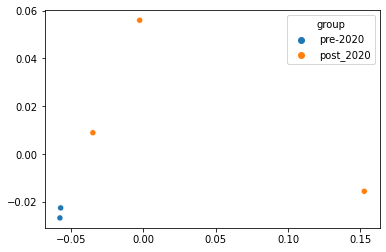

In [66]:
p = processor.plot_cluster(plot_df, color_column = "group")

This plot shows us the information from the heat map reduced to two dimensions for plotting. We can see that the 2018 and 2019 reports are very similar to each other in terms of substance, while the post-2020 reports are more unique.

## Topic modelling with BERTopic <a class="anchor" id="5"></a>
The library also supports topic modelling with BERTopic. The first step is to train a model on a set of IDs. In this case, the corpus is small enough that we can train a single model with all the documents.

In [ ]:
processor.train_bertopic_model(
    text_ids = text_ids, # which text ids to include in the model
    model_name = "all_documents", # will save the model under this directory in the data_path/bertopic_models/ path
    notes = "notes", # notes on this model
    split_by_n_words = None # leave None to split longer documents by page, or put an integer to split them by that number of words
)

Now we will find a trained BERTopic model in `data/bertopic_models/{model_name}/model`. A file `data/bertopic_models/model_metadata.csv` file was also created, with columns:
* `model_name`: the name of the model as passed to the `model_name` parameter
* `notes`: notes on the model as passed to the `notes` parameter
* `text_ids`: a list of text IDs that went into training the model
* `document_ids`: for technical purposes, how many pages/word splits each text ID required, since BERTopic works better with many shorter documents
* `split_by_n_words`: `None` if the documents were split by page, the number of words passed if split by number of words

We can also load the trained model in case we want to do anything specific with it that is not already built into the library.

In [68]:
model = processor.load_bertopic_model(model_name = "all_documents")

In [69]:
model.get_topic_info()

Topic  Count                                     Name
0      -1    139            -1_imf_sdr_countries_economic
1       0     84      0_development_capacity_imf_training
2       1     47        1_imf_surveillance_board_external
3       2     36                    2_page_imf_alamy_left
4       3     31            3_quota_percent_credit_access
5       4     27              4_debt_countries_global_imf
6       5     19          5_data_digital_istock_financial
7       6     19                 6_billion_sdr_quotas_imf
8       7     12       7_fund_monetary_international_part
9       8     12     8_department_irector_director_office
10      9     11  9_inequality_economies_countries_people

For instance this shows us the topics and counts thereof. Since we split our documents by page, `Count` here refers to number of pages with this topic.

**Visualize a BERTopic model** <a class="anchor" id="5.1"></a>

In [ ]:
processor.visualize_bertopic_model(
    model_name = "all_documents",
    method_name = "visualize_topics", # method name from BERTopics various options
    plot_name = "visualize_topics"
)

This will create an HTML file in `data/bertopic_models/{model_name}/{plot_name}.html` containing the plot. Available options for plotting (i.e., what to pass to the `method_name` parameter) are:
* `visualize_topics`
* `visualize_documents`
* `visualize_hierarchy`
* `visualize_barchart`
* `visualize_heatmap`
* `visualize_topics_over_time`
* `visualize_topics_presence`

Examples of all are saved in the `data/bertopic_models/all_documents/` directory. You can also pass additional arguments of the [BERTopic visualization functions](https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html).

In [ ]:
# only plotting the top 5 topics
processor.visualize_bertopic_model(
    model_name = "all_documents",
    method_name = "visualize_topics",
    plot_name = "visualize_topics_top_5",
    top_n_topics = 5 # this is an argument for the native visualize_topics() function from BERTopic
)

In [ ]:
processor.visualize_bertopic_model(
    model_name = "all_documents",
    method_name = "visualize_documents",
    plot_name = "visualize_documents"
)

In [ ]:
processor.visualize_bertopic_model(
    model_name = "all_documents",
    method_name = "visualize_hierarchy",
    plot_name = "visualize_hierarchy"
)

In [ ]:
processor.visualize_bertopic_model(
    model_name = "all_documents",
    method_name = "visualize_barchart",
    plot_name = "visualize_barchart"
)

In [ ]:
processor.visualize_bertopic_model(
    model_name = "all_documents",
    method_name = "visualize_heatmap",
    plot_name = "visualize_heatmap"
)

The over time plot needs timestamps passed to the `timestamps` argument, corresponding to the timestamps for each text ID the model was trained on.

In [ ]:
timestamps = [
    datetime.datetime.strptime("2022-01-01","%Y-%m-%d"),
    datetime.datetime.strptime("2021-01-01","%Y-%m-%d"),
    datetime.datetime.strptime("2020-01-01","%Y-%m-%d"),
    datetime.datetime.strptime("2019-01-01","%Y-%m-%d"),
    datetime.datetime.strptime("2018-01-01","%Y-%m-%d"),
]
processor.visualize_bertopic_model(
    model_name = "all_documents",
    method_name = "visualize_topics_over_time",
    plot_name = "visualize_topics_over_time",
    timestamps = timestamps
)

The `visualize_topics_presence` plot will generate a PNG instead of an HTML. It additionally can take the `presence_text_ids` and `presence_topic_ids` arguments. If you have many documents, this plot can get noisy. You can restrict it to only some topics and text IDs by passing lists to these parameters.

plot saved to data/bertopic_models/all_documents/visualize_topics_presence.*


text_id                                         1         2         3  \
topic_desc                                                              
-1_imf_sdr_countries_economic            0.000000  0.000000  0.000000   
0_development_capacity_imf_training      0.098215  0.097523  0.087230   
1_imf_surveillance_board_external        0.096349  0.065090  0.041386   
2_page_imf_alamy_left                    0.067803  0.077202  0.156185   
3_quota_percent_credit_access            0.080807  0.089645  0.099237   
4_debt_countries_global_imf              0.096271  0.065838  0.085472   
5_data_digital_istock_financial          0.022663  0.026041  0.014925   
6_billion_sdr_quotas_imf                 0.048433  0.063926  0.000000   
7_fund_monetary_international_part       0.036553  0.080040  0.000000   
8_department_irector_director_office     0.012500  0.000000  0.014925   
9_inequality_economies_countries_people  0.036466  0.054054  0.029851   

text_id                                         4         5  
topic_desc                                                   
-1_imf_sdr_countries_economic            0.000000  0.000000  
0_development_capacity_imf_training      0.166764  0.204797  
1_imf_surveillance_board_external        0.151976  0.125995  
2_page_imf_alamy_left                    0.041691  0.011650  
3_quota_percent_credit_access            0.042535  0.044293  
4_debt_countries_global_imf              0.063772  0.009221  
5_data_digital_istock_financial          0.068898  0.050423  
6_billion_sdr_quotas_imf                 0.040667  0.044451  
7_fund_monetary_international_part       0.009259  0.018519  
8_department_irector_director_office     0.046196  0.046196  
9_inequality_economies_countries_people  0.009259  0.009259

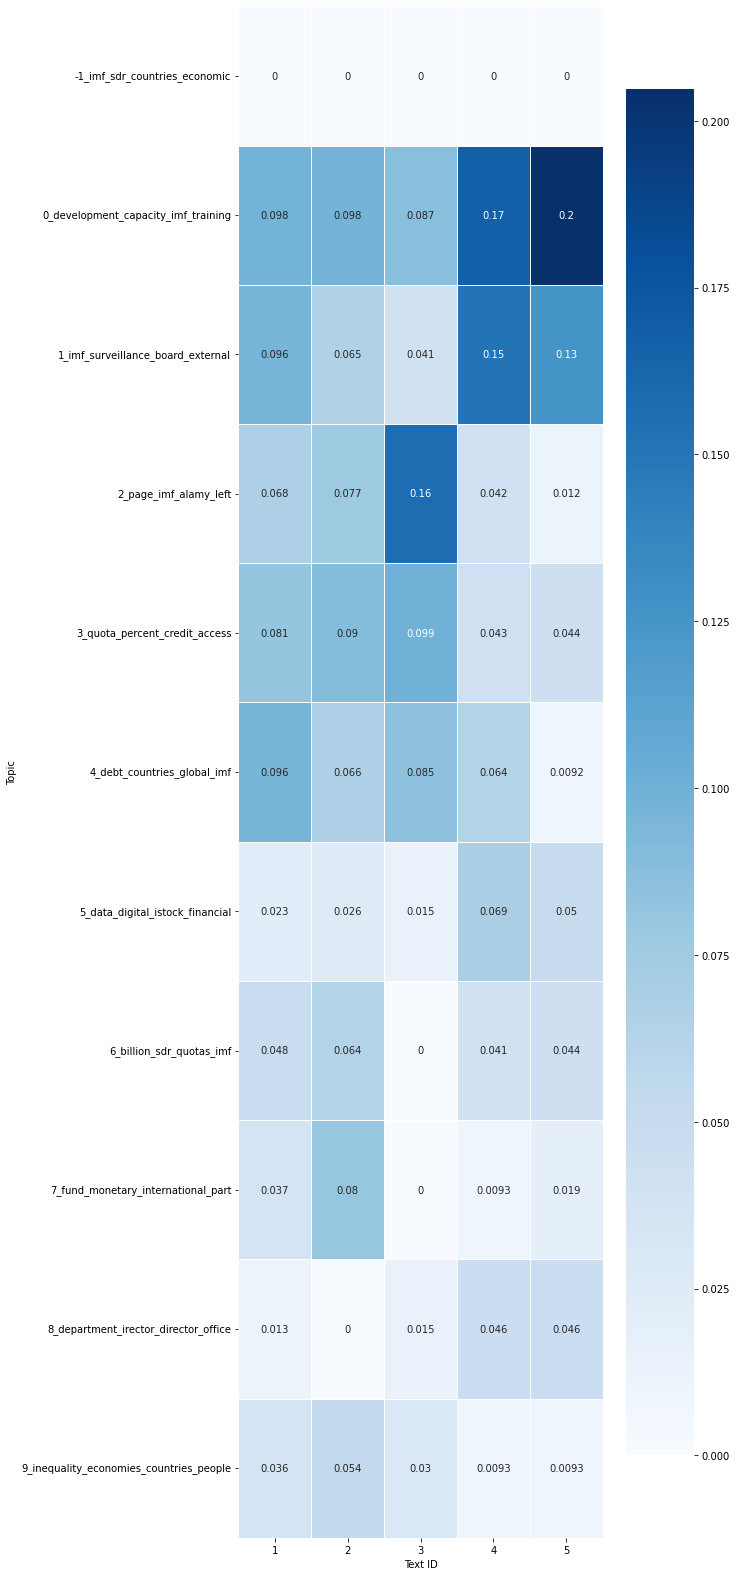

In [85]:
# plot all topic and text IDs
processor.visualize_bertopic_model(
    model_name = "all_documents",
    method_name = "visualize_topics_presence",
    plot_name = "visualize_topics_presence"
)

This will show you what percentage of pages/subdocuments (e.g., 500 word chunks if you passed 500 to the `split_by_n_words` parameter when you initially trained your model) each topic appears in each document. For instance, for text ID 3, 2020's report, the topic on capacity development and training appears in about 9% of pages, while the topic on SDRs and quotas does not appear.

plot saved to data/bertopic_models/all_documents/visualize_topics_presence_fewer.*


text_id                                    3
topic_desc                                  
0_development_capacity_imf_training  0.08723
7_fund_monetary_international_part   0.00000

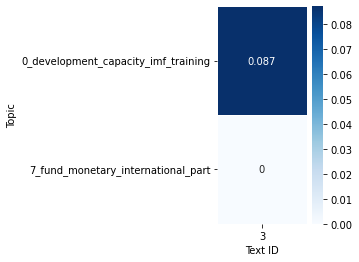

In [86]:
# plot subselection of topics and text IDs
processor.visualize_bertopic_model(
    model_name = "all_documents",
    method_name = "visualize_topics_presence",
    plot_name = "visualize_topics_presence_fewer",
    presence_text_ids = [3], # only produce the plot for 2020
    presence_topic_ids = [0, 7] # only produce the plot for topics 0 and 7
)